In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import numpy as np
import json

def cut_label(input_filename, output_filename):
    # 读取JSON文件
    with open(input_filename, 'r') as file:
        data = json.load(file)
    
    # 筛选出flag字段不等于[]的元素
    filtered_data = [item for item in data if item['flag'] != []]
    
    # 将筛选后的数据写回到另一个JSON文件
    with open(output_filename, 'w') as file:
        json.dump(filtered_data, file, indent=4)
        
    return filtered_data

def model_run(filename):
    with open(filename, 'r') as file:
        all_data = json.load(file)

    # 提取特征和标签到数组
    X = np.array([[item['LOF_Score'], item['Cos_Score'], item['LDA_Score']] for item in all_data])
    y = np.array([item['flag'] for item in all_data])

    Xy = list(zip(X, y))

    # 打乱数据
    Xy_shuffled = shuffle(Xy, random_state=42)

    # 再次分离特征和标签
    X_shuffled, y_shuffled = zip(*Xy_shuffled)
    X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=42)

    # 特征缩放
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


    # 使用二元逻辑回归初始化模型
    model = SGDClassifier(
        loss='log_loss',  # 逻辑回归损失
        learning_rate='constant',
        eta0=0.01,  # 初始学习率
        max_iter=1000,  # 最大迭代次数
        tol=1e-3,  # 停止准则的公差
        alpha=0.01  # 正则化强度
    )

    # 训练模型
    model.fit(X_train, y_train)

    # 使用模型进行预测
    test_predictions = model.predict(X_test)
    weights = model.coef_[0]  # 获取权重
    print("权重占比:", weights)
    
    # 预测概率
    y_train_pred_prob = model.predict_proba(X_train)
    y_test_pred_prob = model.predict_proba(X_test)
    # 计算损失
    train_loss = log_loss(y_train, y_train_pred_prob)
    test_loss = log_loss(y_test, y_test_pred_prob)
    print(f"Training Loss: {train_loss}")
    print(f"Testing Loss: {test_loss}")

    # 计算和打印评估指标
    accuracy = accuracy_score(y_test, test_predictions)
    precision = precision_score(y_test, test_predictions)
    recall = recall_score(y_test, test_predictions)
    cm = confusion_matrix(y_test, test_predictions)
    TN, FP, FN, TP = cm.ravel()
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')
    print(f"True Negatives (TN): {TN}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"True Positives (TP): {TP}")
    return model,weights

def cut_no_label(input_filename,output_filename):
    with open(input_filename, 'r') as file:
        data = json.load(file)
    
    # 筛选出flag字段等于[]的元素
    filtered_data = [item for item in data if item.get('flag') == []]
    with open(output_filename, 'w') as file:
        json.dump(filtered_data, file, indent=4)
    return filtered_data

def renew(X_3,Matched_Predictions,filename):
    with open(filename,'r') as file:
        data = json.load(file)
    for i, index in enumerate(X_3):
        for item in data:
            if item['index'] == index:
                item['flag'] = int(Matched_Predictions[i])
                break
    with open(filename, 'w') as file:
        json.dump(data, file, indent=4)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

for i in range(100,2000,100):
    print(f'i: {i}')
    #文件中选取含有flag的数值
    cut_label('Merged_Data.json', 'cut_label.json')
    #运行model
    # weights, test_predictions, model =model_run('cut_label.json')
    model,weights =model_run('cut_label.json')
    #选取文件中不含有flag的元素
    filtered_elements = cut_no_label('Merged_Data.json', 'cut_no_label.json')
    #model的预测
    X = np.array([[item['LOF_Score'], item['Cos_Score'], item['LDA_Score']] for item in filtered_elements])

    scores = np.dot(X, weights)
    # probabilities = sigmoid(scores)
    # print(f'{probabilities}')

    Predict = model.predict(X)
    Posibility = model.predict_proba(X)[:,1]
    # print(f'Predict:{Predict}')
    # print(f'Posibility: {Posibility}')
    X_1 = [(item['index'], Posibility[i]) for i, item in enumerate(filtered_elements)]
    X_2 = sorted(X_1, key=lambda x: (-abs(x[1] - 0.5), x[0]))
    # print(f'{X_2}')
    top_100 = X_2[:100]
    X_3 = [item[0] for item in top_100]
    # print(f'{X_3}')
    Matched_Predictions = []
    for original_index in X_3:
        position = next((i for i, item in enumerate(filtered_elements) if item['index'] == original_index), None)
        if position is not None:
            Matched_Predictions.append(Predict[position])
        else:
            continue
    renew(X_3,Matched_Predictions,'Merged_Data.json')



***还存在一些困惑***

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
from imblearn.over_sampling import SMOTE

def cut_label(input_filename, output_filename):
    with open(input_filename, 'r') as file:
        data = json.load(file)

    filtered_data = [item for item in data if item['flag'] != []]

    with open(output_filename, 'w') as file:
        json.dump(filtered_data, file, indent=4)
        
    return filtered_data

def cut_no_label(input_filename,output_filename):
    with open(input_filename, 'r') as file:
        data = json.load(file)

    filtered_data = [item for item in data if item.get('flag') == []]
    with open(output_filename, 'w') as file:
        json.dump(filtered_data, file, indent=4)
    return filtered_data

class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) # 第一個全連接層
        self.fc2 = nn.Linear(hidden_size, hidden_size) # 第二個全連接層
        self.fc3 = nn.Linear(hidden_size, 1) # 輸出層

    def forward(self, x):
        x = F.relu(self.fc1(x)) # 使用ReLU激活函數
        x = F.relu(self.fc2(x)) # 使用ReLU激活函數
        x = torch.sigmoid(self.fc3(x)) # 最後的輸出使用sigmoid激活函數
        return x

def model_run(filename):
    with open(filename, 'r') as file:
        all_data = json.load(file)

    X = np.array([[item['LOF_Score'], item['Cos_Score'], item['LDA_Score']] for item in all_data])
    y = np.array([item['flag'] for item in all_data])

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 分割数据集为训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # 应用SMOTE重采样
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # 将重采样后的数据转换为张量
    X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32)

    # 构建模型
    input_size = 3
    hidden_size = 10
    model = BinaryClassifier(input_size, hidden_size)

    # 定义损失函数和优化器
    criterion = nn.BCELoss()  # 由于应用了SMOTE，可能不需要pos_weight
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    threshold = 0.5
    # 训练模型
    num_epochs = 1000
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs.squeeze(), y_train_tensor)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        # 将数据转换为张量
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
        # 进行模型预测
        predictions = model(X_test_tensor)
        # 将输出转换为类别（0或1）
        predicted_classes = (predictions > threshold).float()
        # 计算准确率
        accuracy = (predicted_classes == y_test_tensor).float().mean()
        print(f'Accuracy: {accuracy.item()*100:.2f}%')

    # 如果需要更多评估指标，如混淆矩阵、精确率、召回率等，你可以使用sklearn.metrics模块来计算
    # 混淆矩阵
    conf_matrix = confusion_matrix(y_test, predicted_classes.numpy())
    print("Confusion Matrix:")
    print(conf_matrix)
    # 其他指标
    print("Classification Report:")
    print(classification_report(y_test, predicted_classes.numpy()))
    return model,predicted_classes,y_test

def renew(X_3,Matched_Predictions,filename):
    with open(filename,'r') as file:
        data = json.load(file)
    for i, index in enumerate(X_3):
        for item in data:
            if item['index'] == index:
                if Matched_Predictions[i] > 0.5:
                    item['flag'] = 1
                else:
                    item['flag'] = 0
                break
    with open(filename, 'w') as file:
        json.dump(data, file, indent=4)


# 初始化一些早停参数
best_macro_avg = 0.0  # 到目前为止观察到的最好的F1分数
patience = 5  # 早停耐心参数：在多少个迭代中没有改进后停止训练
no_improvement_count = 0  # 记录没有改进的迭代次数
for i in range(100,23000,100):
    print(f'i: {i}')
    cut_label('Merged_Data.json', 'cut_label.json')
    model, predicted_classes, y_test = model_run('cut_label.json')

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predicted_classes, average='macro')
    macro_avg = (precision + recall + f1) / 3
    print(f'Epoch {i}: Macro Avg F1-Score: {macro_avg:.4f}')
    # if macro_avg > best_macro_avg:
    #     best_macro_avg = macro_avg  # 更新最好的F1分数
    #     no_improvement_count = 0  # 重置没有改进的计数器
    # else:
    #     no_improvement_count += 1  # 没有改进，则计数器加一
    # if no_improvement_count >= patience:
    #     model = model_save
    #     print("Early stopping triggered due to no improvement.")
    #     break
    model_save = model
    filtered_elements = cut_no_label('Merged_Data.json', 'cut_no_label.json')
    X = np.array([[item['LOF_Score'], item['Cos_Score'], item['LDA_Score']] for item in filtered_elements])
    X_tensor = torch.tensor(X, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
    X_1 = [(item['index'], outputs[i]) for i, item in enumerate(filtered_elements)]
    X_2 = sorted(X_1, key=lambda x: (-abs(x[1] - 0.5), x[0]))
    top_100 = X_2[:100]
    X_3 = [item[0] for item in top_100]
    Matched_Predictions = [item[1] for item in top_100]
    renew(X_3,Matched_Predictions,'Merged_Data.json')


i: 100
Epoch [100/1000], Loss: 0.6562
Epoch [200/1000], Loss: 0.5779
Epoch [300/1000], Loss: 0.4155
Epoch [400/1000], Loss: 0.2512
Epoch [500/1000], Loss: 0.1551
Epoch [600/1000], Loss: 0.1006
Epoch [700/1000], Loss: 0.0687
Epoch [800/1000], Loss: 0.0494
Epoch [900/1000], Loss: 0.0371
Epoch [1000/1000], Loss: 0.0289
Accuracy: 90.50%
Confusion Matrix:
[[19  0]
 [ 0  1]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00         1

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Epoch 100: Macro Avg F1-Score: 1.0000
i: 200
Epoch [100/1000], Loss: 0.6802
Epoch [200/1000], Loss: 0.6632
Epoch [300/1000], Loss: 0.6350
Epoch [400/1000], Loss: 0.5780
Epoch [500/1000], Loss: 0.4639
Epoch [600/1000], Loss: 0.3414
Epoch [700/1000], Loss: 0.2671
Epoch [800/1000]

KeyboardInterrupt: 

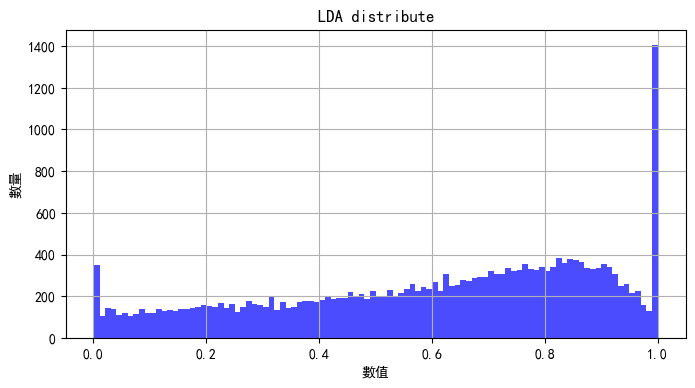

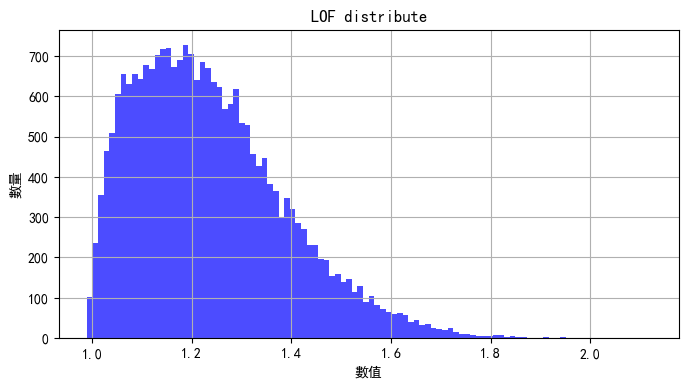

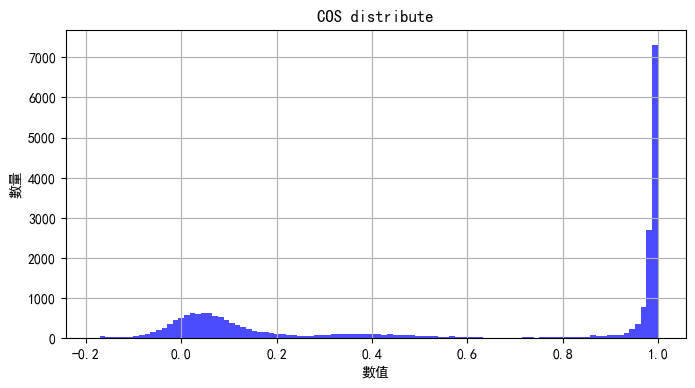

In [1]:
import json
import matplotlib.pyplot as plt

# 读取 JSON 文件
with open('Merged_Data.json', 'r') as file:
    all_data = json.load(file)


plt.rcParams['font.sans-serif'] = ['SimHei']  # 'SimHei' 是一种常用的中文黑体
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 准备空列表来存储特征数据
LDA_data = []
LOF_data = []
COS_data = []

LDA_data = [data["LDA_Score"] for data in all_data[:24533] if data["LDA_Score"] != None]
LOF_data = [data["LOF_Score"] for data in all_data[:24533]]
LOF_reciprocals = [1 / score if score != 0 else 0 for score in LOF_data]
COS_data = [data["Cos_Score"] for data in all_data[:24533]]


def plot_histogram(data, title):
    plt.figure(figsize=(8, 4))
    plt.hist(data, bins=100, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel('數值')
    plt.ylabel('數量')
    plt.grid(True)
    plt.show()

# 繪製直方圖
plot_histogram(LDA_data, 'LDA distribute')
plot_histogram(LOF_data, 'LOF distribute')
plot_histogram(COS_data, 'COS distribute')